<a href="https://colab.research.google.com/github/paulodowd/SEMTM0042_43/blob/main/L1_Motors_SEMTM0042_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labsheet 1: Motors

**Aims:**

In this labsheet we will learn about:

- Built in Arduino functions `pinMode()`, `analogWrite()` and `digitalWrite()` to operate the motors.
- Motor tolerances and **dead-band**, and their consequences.
- The important difference between **open-loop** and **closed-loop** control.
- The utility of **rotary encoders**.
- A simple low-pass filtering technique (exponential moving average).
- How to tune a PID speed controller.


**Objectives:**

We need to operate the motors of the robot and ensure:
 - The motors can drive the robot forwards and backwards.
 - The motors can rotate the robot.
 - We can control the motors by **velocity** (measured speed), rather than **power**.
 - The motor operation is reliable, or does not do unexpected things.
 - Be confident that there are no bugs or errors in our code.  



**Context:**

In Assessment 1, your robot will need to move around.  Getting your robot to move is a primary requirement.  Furthermore, future behaviours will depend on **how well** your robot can move.  So you want to make sure we understand this subsystem, and that it works reliably.

We will discover in this labsheet that:
- DC motors typically do not operate well at low power or low velocity.  This can make fine control of rotation difficult.
- DC motors are often not identical in their characteristics, meaning that the same power provided to each motor does not create the same velocity.  This can make moving in a straight line challenging.
- DC motors will operate differently under different loads: for example, ascending or descending an inclined surface, or encountering different surface reistance (e.g., carpet versus a tabletop).
- We can employ **closed-loop control** to mitigate these effects and make motor operation reliable.












  








<hr><br><br><br><br>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:**
To test any code you write for motors, you will need to enable the battery power on your 3Pi+.<br><br><br>
- There is a small button labelled `Power` on the top of the 3Pi+.  Press once to turn on, and press once again to turn off.  
- When battery power is `on`, a blue LED light will shine next to the button.
- When you are not using the motors, you can increase the longevity of your batteries by turning battery power off.  
- Except motors, all other devices on the 3Pi+ can be used on USB power alone.  
- The 3Pi+ can be plugged into USB and use battery power simultaneously.

<p align="center">
<img width="50%" src="https://github.com/paulodowd/SEMTM0042_43/blob/main/Images/3PI_BattPowerBtn.png?raw=true">
</p>
<br><br><br><br>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left"> The most common cause of damage to the 3Pi+ robot is when it falls off a table at high speed.  **This bends the wheel axle, which is permanent damage**.  Whilst you are testing code, you can use something to lift the robot off the surface, or turn it upside-down - that way it won't run away, fall, and break.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left"> Allowing the motor to **run at high speed for a long time** will cause the motor to **overheat** and become **permanently damaged**.  You will **smell this happening** - don't let it happen!  If you have a problem with your code you **should turn the robot off whilst you work on solving it**.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left"> Forcing a wheel to stop when it is being powered can cause irreversible damage to your 3Pi+.  **This will destroy the gears** inside the reduction gearbox.  Only stop the motors by **turning off the robot**, or by sending the `analogWrite()` command with a value of `0`.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/tick.png" align="left">

The maximum possible power (a value of 255) for the motors is not useful.  You want to program your robot to be under reliable control - so consider limiting the value you send to `analogWrite()` in your code.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/tick.png" align="left"> Your solution later  may accidentally send "bad" values to the motors - by following the exercises in this labsheet, we will have written code to **catch these exceptions** and produce **safe, predictable behaviour**.  It is worth bearing in mind that you are assembling a solution of sub-components.

<hr><br><br><br><br>

# <img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/theory.png" align="left"> Theory: 3Pi+ Motor Drivers

The 3Pi+ robot is controlled by an ATMEL ATMEGA32u4 Microcontroller (<a href="https://www.microchip.com/en-us/product/ATmega32U4">produce page</a>, <a href="https://ww1.microchip.com/downloads/en/DeviceDoc/Atmel-7766-8-bit-AVR-ATmega16U4-32U4_Datasheet.pdf">datasheet</a>).  We can think of a microcontroller as a computer which interacts with the external world (any connected peripherals) through `general purpose input/output` pins (GPIO pins) - the small metal tabs or legs around the actual microchip.  We can write a program (software) to tell the microcontroller to activate a pin `HIGH`, which provides a small amount of current (typically, 25 milliamps).  However, the voltage and current provided by the microcontroller is not enough to drive (activate) the motors of the 3Pi+.  Therefore, the microcontroller of the 3Pi+ will send a signal to another chip - a motor driver - which will in turn activate the motors with more power.

We can look at the schematic of the 3Pi+ (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">aviailable here</a>) to investigate how the motors can be driven.

<p align="center">
<img src="https://github.com/paulodowd/SEMTM0042_43/blob/main/Images/3PI_schematic_drv8838.png?raw=true">
</p>

In the above circuit schematic extract (found on page 2 of the linked document above), we can see the circuit symbol for the left and right motors (the blue circle on top of a blue box).  These are then attached to the integrated circuit (a microchip, the yellow box) labelled `DRV8838`, one for the left motor and one for the right motor.  

Each motor is electronically driven by a DRV8838, a low-voltage H-Bridge driver (a datasheet is available <a href="https://www.ti.com/lit/ds/symlink/drv8838.pdf?ts=1626947113238&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FDRV8838">here</a>).  A <a href="https://en.wikipedia.org/wiki/H-bridge">H-Bridge</a> is a type of circuit which allows DC motors to be driven either forwards or backwards without needing to physically change the polarity of the connections to the DC motor.  

The fine black lines extending out of the yellow block indicate necessary connections to the DRV8838:  
- The DRV8838 is able to source (provide) more voltage and current through the connection labelled `VM` ("voltage-motors"), which is an alternative power supply.  This provides an independent power supply for the motors.
- The connection labelled `5V` provides a stable voltage supply for the digital logic of the DRV8838 circuit.  
- The DRV8838 has to be connected to ground (0v) to complete the electronic circuit, marked by the symbol which looks like a triangle of horizontal lines.  
- The labels `OUT1` and `OUT2` are attached to the DC motor.  By making one output `HIGH` and other `LOW`, the motor is driven forwards or backwards.
- We can observe that both the DRV8838 have connections labelled `PH` and `EN`:
  - Note: `PH` and `EN` appear to have an arrow indicated into them, but the lines are not terminated against a symbol.  This means they connect to another part of the circuit, drawn elsewhere.  
  - The red labels `D16`, `D10`, `D15`, `D9` can be found elsewhere in the document, which is their corresponding connection.  These are connections to our 32u4 microcontroller.
  - We can confirm these connections against the <a href="https://www.pololu.com/docs/0J83/5.9">pin assignment section of the documentation</a> (look for functions relating to motor).

The 3PI+ DRV8838 therefore have just two input signals each for their operation:

- The **`PH`** pin of the DRV8838 sets the **`direction`** of rotation of the motor of the 3Pi+.  In the pin assigment documentation, this is referred to as "left/right motor direction".

- The **`EN`** pin of the DRV8838 `enables` the motors.  When `EN` is set `LOW`, the motors are `not active`.  When `EN` is set `HIGH`, the motors are driven from the power supply `VM`.  In order to achieve different rotation speeds, `EN` is switched on-and-off very quickly.  In the pin assigment documentation, this is referred to as "left/right motor PWM".

`PWM` stands for Pulse Width Modulation.  Pulse Width Modulation means turning a digital signal either `HIGH` or `LOW` (`ON` or `OFF`) within a fixed period of time, and adjusting the timing interval of the signal.  This is often referred to as a `mark-to-space ratio`, because of the way the output signal appears, which forms the `duty-cycle` in %:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/SEMTM0042_43/blob/main/Images/PWM.png?raw=true">
</p>

In the above, we can see that at a 50% duty cycle, the signal has clear and equal on-periods and off-periods, or marks and spaces respectively.  When this PWM signal is measured by the microcontroller, it is effectively averaged over time.  Therefore, a PWM with a 50% duty cycle will be measured as 2.5volts. When we instruct a microcontroller to generate PWM, we are crudely synthesising an analog signal (continuous range) from a digital signal (binary range), which is often referred to as `DAC` - digital-to-analog conversion.  The DRV8838 receives the PWM output from the 32u4 microcontroller and will effect different motor power levels.  

The DRV8838 makes operating the motors very easy, we simply set a **`PWM`** level (power), and a **`direction`**.  The 3Pi+ is a **`differential drive`** robot from Pololu. This means it has two wheels as **`effectors`**, placed symmetrically either side of the longitude of the robot, to manoeuvre the robot.  Each wheel is driven by a motor each, the **`actuators`**.  
- To make the 3Pi+ move forwards or backwards the motors can be activated with the same **`PWM`** levels, set in the same **`direction`**.  
- The 3Pi+ can be made to move on an **`arc`** by activating the motors at different **`PWM`** levels, in the same **`direction`**.
- The 3Pi+ can be made to rotate on the spot by activating the motors at the same **`PWM`** levels, in different **`directions`**.

Conveniently, most microcontrollers contain dedicated hardware to generate PWM signals - meaning it is not necessary to write our own software routine to do so.  Within the Arduino programming environment, a function called **`analogWrite()`** performs this operation (<a href="https://www.arduino.cc/reference/en/language/functions/analog-io/analogwrite/">Arduino Reference</a>).  Writing a value of 255 creates a constant high signal (5v), whilst writing a 0 creates a constant low signal (0v).  Values between 0 and 255 generate square waveforms with a ratio of high (5v) and low (0v).  

It is important to note that when we set a `PWM` level as input to the DRV8838, we are setting a desired output power level but **not** speed.  **Speed** (or velocity) is a measurement, and currently we do not know the real rotation of the wheel during a period of time.  Imagine, we could set an output PWM duty cycle of 100%, but the DC motor could be broken - a measured speed of 0.


<hr><br><br><br><br>

# Safe Motor Operation

## Exercise 1: Safe Motor Operation

For these exercises, review the **code stub** <a href="https://github.com/paulodowd/SEMTM0042_43/tree/main/3Pi_CodeStub">available on Github</a>.  In particular, you will need to edit `Motors.h`.



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/hypothesis.png" align="left">**Hypothesise:** In the above circuit extract, we can see a tiny arrow next to the symbol for the motors.  This arrow indicates the normal direction of the motor.  These arrows are pointing in different directions.  Why may the circuit and hardware have been specified in this way? <br><br><br>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** You should review the `Motors.h` file specifically.  You will need to complete all areas marked with `????`.  You will need to `uncomment` code by removing the `//` (comment syntax) text.  The first one, `#define L_PWM 10` is correct, the others need fixing.

1. Complete the pin definitions `L_PWM`, `L_DIR`, `R_PWM` and `R_DIR`.  You will need to refer to the **documentation** available online <a href="https://www.pololu.com/docs/0J83/5.9">here</a> (https://www.pololu.com/docs/0J83/5.9).
  - Use the column labelled **Arduino pin names**, and **use the first value in the cell** (e.g., `10` for `Left motor PWM`).

2. Complete the function inside the `Motors_c` class definition called `intialise()`.  There are comments in the code to help you.
  - Using the pin definitions you just completed, decide whether the pins should be activated as `INPUT` or `OUTPUT` - what will they do?
  - Using the pin definitions you just completed, decide what initial value they should have.  When you turn on your robot, what do you want to happen first of all?

3. Complete the function inside the `Motors_c` class definition called `setPWM()`.  There are comments in the code to help you.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Check that you have assigned the left and right pins appropriately.  When you validate your own work, it is best to test one thing at a time.  Work slowly and methodically.  For example, use `motors.setPWM( 0, 25 );` to set the left motor to power 0 (off), and the right motor to power 25.  This way, we focus on just 1 motor, and we use a value that should be "safe" (not extreme, not negative, etc.)



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left">

 Lift your robot off the surface for these exercises, or it will drive off the table and become damaged.  **You could turn it upside-down.**

- Does activating just the left motor in code activate the left motor in reality?  What about the right motor, is that correct?
- When you send a **positive** value to the motor, does it rotate **forwards** or **backwards**?  Which makes more sense to you?
- It is recommended you then create and use `#define FWD LOW` (or HIGH?), and `#define REV LOW` (or HIGH?) definitions in your code.
  - You can then use `FWD` and `REV` instead of `HIGH` and `LOW`, where `#define` is acting like a find-and-replace operation.
  - This helps to make your more readable when you ask others for help.
  - This should reduce the probability of bugs because you do not have `HIGH` and `LOW` defined in many places in your code - they are defined just at the top.
- Check what happens if you now send a **negative** value, for example `motors.setPWM( 0, -25 );`
 - Does the correct wheel rotate in the opposite direction?


<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Within `loop()`, write some code that will now use variables rather than **hard-coded values** to set the values for the motors PWM - review the below code extract for a suggestion.  



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left">

 Lift your robot off the surface for these exercises, or it will drive off the table and become damaged.  **You could turn it upside-down.**

4. Start by having the variables "left" and "right" simply increase in value.  
  - Set the initial value of the variables `left` and `right` within `setup()` as `0`.
  - What do you expect the robot to do (what do you **hypothesise** to **observe**)?
  - What do you expect your `Motor_c` `setPWM()` function to do?
5. Next, program the variables "left" and "right" to simply decrease in value.
  - Set a positive starting value, for example `40` - you can set this within `setup()`.
  - The value should decrease past 0 into negative numbers - what do you **hypothesise** to **observe** from your robot as this happens?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Check that your function can handle negative PWM values.  We know that `analogWrite()` can only work with positive numbers.  Therefore, if we send a negative PWM (meaning, to go backwards), we need to first **change the direction pin**, and then pass `analogWrite()` the **absolute** PWM value (positive only).

```c
// to "remember" the last power value outside
// of loop()
float left;
float right;

void setup() {
  // ...
}

void loop() {

  // Update the left and right power to
  // observe how the motors behave.  This
  // operation will happen every time
  // loop() gets run.
  left =  ????;
  right = ????;

  // Send power to motors.
  motors.setPWM( left, right );

  // Do nothing for half a second.
  delay(500);
}
```

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** After the above exercises, you should now decide what are **sensible** PWM values for your motors.  You should have **observed** very high motor speed, which will not be necessary or useful in reality.  

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left">

 Lift your robot off the surface for these exercises, or it will drive off the table and become damaged.  **You could turn it upside-down.**

- Update your `Motors_c` class function `setPWM()` to limit the PWM value to a safe value.  It is recommended you use the `#define MAX_PWM` statement at the top of the class.
  - This will mean you can change this, or disable it, by editing just one line of your code.
  - This should reduce future bugs, where a **hard-coded** value could be forgotten about but changing the performance of your robot.
- Check that your new PWM constrait works by running some of the code from the previous exercises.
  - What happens now when a value like `200` is sent to the motors?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Now that you are confident your robot will behave in the way your predict; explore combinations of left and right motor power values, and how these produce different types of robot motion.  Please be aware that without **closed-loop control**, it is difficult and unlikely that your robot can perform these types of motion reliably.



- Drive forwards in a straight line.
- Drive backwards in a straight line.
- Turn on the spot to the left.
- Turn on the spot to the right.
- Drive on an arc, or move along a circle.
  

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/observation.png" align="left"> **Observations:** Take some time to reflect on what you have observed.  You may have noticed some of the following statements. For each of the below, consider how you might be able to **measure** these characteristics of your robot.  

- Even with the same values sent to the motors (e.g. `motors.setPWM( 30, 30);`) my robot doesn't move in a straight line.
  - From this, we learn that the motors have either different performance characteristics (like power efficiency), or they have different operational factors (such as friction).
  - What would be a simple experiment to **quantify** how much the robot deviates from a straight line of travel?
    - How could we design a scenario to measure this externally to the robot?
    - What sensors does the robot have that could help the robot to autonomously sense this problem?
- Compared to my peers, my robot requires different PWM values to produce the same type of motion (e.g., to drive in a straight line).
  - From this, we learn that the differences between motors occurs between different robots - meaning that robots are different from each other too.
  - Consider the problem of movement speed: If robots will be different from each other, what sensor information could we use, and how could we process this information, to write a program that performed identically on different robots?
- If my robot is going up an incline (e.g., like a hill), the robot slows down.  If my robot is going down an incline, the robot speeds up.
  - From these, we learn that **a PWM value is not a description of speed** (velocity).  We can set a PWM value, but the output speed could still change.
  - From these, we learn that external factors can influence the performance or behaviour of a robot.

<hr><br><br><br><br>

## Exercise 2: Leaving the Start Box

<img width="100px" src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/calibration_disk.png" align="left"> For Assessment 1, your 3Pi+ robot must start in the "start box" area, which you can find with the marker illustrated to the left. Your robot must leave this start area to begin the task.  Therefore, a good first problem to try and solve is to have the robot move forward for a given duration, then stop. In Labsheet 0, you wrote a **non-blocking** function to activate the buzzer for a fixed duration - that would be the best approach to take here!


<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Update your program so that your robot can be placed in the starting box of the coursework map, leave the starting box, and then stop when it has moved outside the area of the box.  Currently, you'll need to use `millis()` to set a time duration of movement.

1. In Labsheet 0, we wrote two functions for a **non-blocking** beep routine: `setBeep()` and `checkBeep()`.  This allowed us to produce a beep of a specified duration without using any `delay()` functions.   You are encouraged to adapt your `setBeep()` and `checkBeep()` functions.  Keeping a copy, rename these to something like `setForwards()`, `checkForwards()`.  
  - Write your `setForwards()` function so that you can specify a duration as an argument in milliseconds().  When `setForwards()` is called, it should activate the motors to cause your robot to move forwards.
  - Call `checkForwards()` within your `loop()`, which will simply stop the robot once the requested duration has elapsed.  Otherwise, it will do nothing.  Doing nothing will mean that if `setForwards()` activated the motors to turn, they will continue to turn the robot.
  - It would be useful to know if the robot is currently operating a turn routine.  Therefore, update your `checkForwards()` routine to have the return type `bool`.
    - When the code within `checkForwards()` evaluates as within the requested duration (still travelling), return `true` to indicate that a turn operation is in progress.
    - When `checkForwards()` evaluates as the duration having passed, stop the motors, and return `false` to indicate the robot is no longer turning.

2.  Currently, it is likely that your `checkForwards()` function will repeatedly set the motor PWM to 0 after the requested duration.  Make use of a **global variable** to act as a flag, so that once the motors are deactivated, future calls to `checkForwards()` will not deactivated the motors repeatedly.



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** Try to avoid writing code in your `loop()` that looks like the following code extract.  This is because, if you write your robot controller as a long script like this, it will quickly become extremely complicated to debug.  It will also be extremely difficult to transfer any of your code or solutions into future work - such as Assessment 2.  

It is also important to note that using `delay()` like this will introduce error into the kinematic estimate of the robot position, which will be required to get the higher achievement marks on Assessment 1.  When you use `delay()`, your robot is not able to do any other computation, and so your robot will not be able to update the estimate of it's position.

Instead, look to use `millis()` to write **non-blocking** code, which was covered in **exercises 5 & 6 of Labsheet 0**.

```c
void loop() {

  beep(); // start up beep and delay
  delay(2000);

  motors.setPWM( 30, 30 ); // forwards

  delay(1500); // wait to leave box

  motors.setPWM( 0, 0 ); // stop the robot

  // stop the program
  while( true ) {
    delay(1000);
  }

}

```

## Exercise 3: A Turn Routine

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Using the a similar structure to your function to move forwards for a specified duration, write a pair of functions that can operate a **non-blocking** turn.


1. There are a number of different approaches that can be taken.   Consider the following empty functions.  Implement at least one, and consider exploring the others:

```c

// The direction and rate of turn is fixed within this function
void setTurn( unsigned long duration_ms ) {

}

// Setting the left and right pwm directly with a duration
void setTurn( float left_pwm, float right_pwm, unsigned long duration_ms) {

}

// Setting a forward bias and a turn bias, with duration
void setTurn( float fwd_bias_pwm, float turn_pwm, unsigned long duration_ms ) {

}

```

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** In labsheet 4, you will be encouraged to adapt these functions to stop using a duration in milliseconds as the stopping criteria, and to instead use an angle in radians, or a distance to a target `x` and `y` coordinate.  Using time and PWM is not very reliable.

<hr><br><br><br><br>

# Review of Open-Loop Control

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/theory.png" align="left"> When the 3Pi+ robot is setting the power to the motorswith `analogWrite()`, there is no guarantee that the motor achieves a stable or consistent wheel speed.  We call this **open-loop control**.  This means that there is some control - we can turn the motor on, off, higher and lower - but we do not know what the actual outcome is (the outcome is open).  Therefore, for the same PWM given to the motor, the actual wheel speed may vary.  If we want to **close the loop**, it would mean measuring the output wheel speed, and then using this to adjust the `analogWrite()` command to achieve a desired stable wheel speed.  

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** For each of the below plots under review, you can expand the cell to view the python code used to generate the plot (click "show code").  You can also review the python code to find the source of the original data in the GitHub repository.  In Assessment 2, you will be required to take measurements from your robotic system and to plot graphs.  It would be smart to become familiar with how to do this in advance.  If you get time, it is recommended to come back and see if you can replicate these results with your robot (i.e., capture the data yourself).  A hidden challenge in this process is capturing data without the USB cable plugged in, and retrieving data once the robot has stopped.

### The Effect of Dead-Band

The plot below shows the wheel speeds of the left and right wheels collected from a 3Pi+ robot.  The robot was operating on a smooth table top without the USB cable plugged in.  The wheel speed is calculated in the change of encoder counts per millisecond.  Encoder data for wheel speed estimation was captured at 100hz (10ms intervals).  10 sample speeds were recorded for each PWM value in the range [-38 : 38 ] at an interval of 2.  

The dashed red line illustrates where the wheel speed is zero.  Relative to this, the dashed blue lines illustrate where wheel speed appears to approximately commence.  Notice that there is a large gap between the two blue lines, across PWM values -12 to +14 .  This is the **dead-band**, where power sent to the motors does not cause motion.  

It is also important to note that:
- the motor response forward is not the same as backward.
- the motor response for left and right wheels are not the same.
- all the 3Pi+ robots will be slightly different, and this is due to **tolerances** (allowable differences) in the manufacturing process.

<Figure size 1000x1600 with 0 Axes>

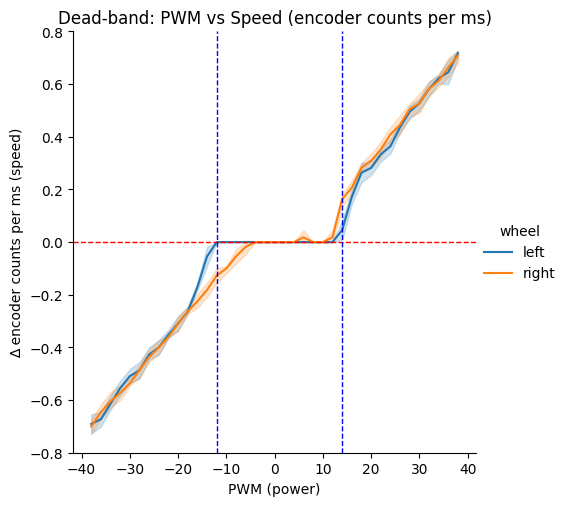

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import CSV stored on github.
# This could be your local computer directory
pwm_speeds = pd.read_csv('https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/refs/heads/main/ExampleData/deadband.csv', sep=',')

pwm_speeds = pwm_speeds[ ( pwm_speeds['PWM'] > -40) & (pwm_speeds['PWM'] < 40) ]

plt.figure(figsize=(10, 16))
lplot = sns.relplot( data=pwm_speeds, x="PWM", y="enc_per_ms", hue="wheel",kind="line")
# Iterate over the axes in the FacetGrid and set the title
lplot.set_axis_labels("PWM (power)", "∆ encoder counts per ms (speed)")
for ax in lplot.axes.flat:
    ax.set_title("Dead-band: PWM vs Speed (encoder counts per ms)")
    ax.axhline(y=0.0, color="red", linestyle="--", linewidth=1)  # horizontal line
    ax.axvline(x=14, color="blue", linestyle="--", linewidth=1)  # vertical line
    ax.axvline(x=-12, color="blue", linestyle="--", linewidth=1)  # vertical line


###  Wheel Speed Differences between Left and Right Motors

The plot below shows the difference in wheel speeds of the left and right wheels collected from a 3Pi+ robot.  The plot shows results for two surfaces: a smooth tabletop, and a rough carpet.  The wheel speed is calculated in the change of encoder counts per millisecond.  Encoder data for wheel speed estimation was captured at 100hz (10ms intervals).  10 sample speeds were recorded for each PWM value in the range [0 : 120 ] at an interval of 4.  

The dashed red line illustrates where the wheel speed is zero.  We can see that whether on carpet or a tabletop, there is a general trend for the difference in wheel speed to be negative. This means that one wheel is always rotating slightly faster than the other.  This trend also seems to get worse at higher PWM values.  The effect of this would be that the robot trajectory would be a curve or arc.

<Figure size 1600x600 with 0 Axes>

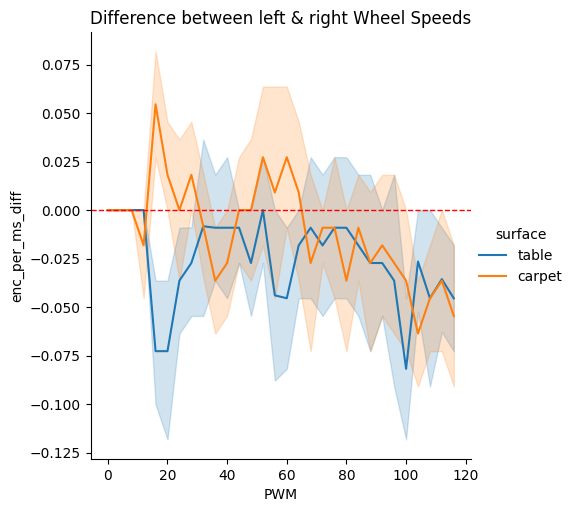

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import CSV stored on github.
# This could be your local computer directory
pwm_speeds = pd.read_csv('https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/refs/heads/main/ExampleData/diffs.csv', sep=',')
#print( pwm_speeds )

# Let's look at a smaller range of the total PWM
plt.figure(figsize=(16, 6))
lplot = sns.relplot( data=pwm_speeds, x="PWM", y="enc_per_ms_diff", hue="surface", kind="line")
for ax in lplot.axes.flat:
    ax.set_title("Difference between left & right Wheel Speeds")
    ax.axhline(y=0.0, color="red", linestyle="--", linewidth=1)  # horizontal line



### The Effect of the Task Surface on Wheel Speed

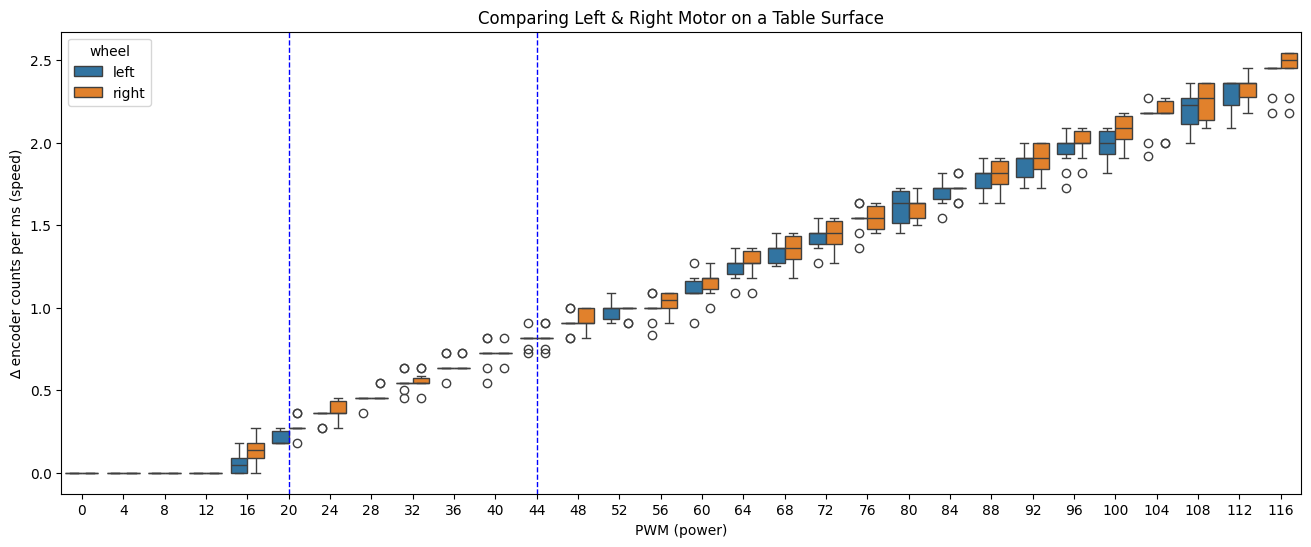

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import CSV stored on github.
# This could be your local computer directory
pwm_speeds = pd.read_csv('https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/refs/heads/main/ExampleData/surfaces.csv', sep=',')
#print( pwm_speeds )

# Let's look at a smaller range of the total PWM
pwm_speeds = pwm_speeds[ pwm_speeds['surface'] == 'table' ]
plt.figure(figsize=(16, 6))
bplot = sns.boxplot( data=pwm_speeds, x="PWM", y="enc_per_ms", hue="wheel")
bplot.set_title("Comparing Left & Right Motor on a Table Surface")
bplot.set_xlabel("PWM (power)")
bplot.set_ylabel("∆ encoder counts per ms (speed)")
bplot.axvline(x=5, color="blue", linestyle="--", linewidth=1)
bplot.axvline(x=11, color="blue", linestyle="--", linewidth=1)

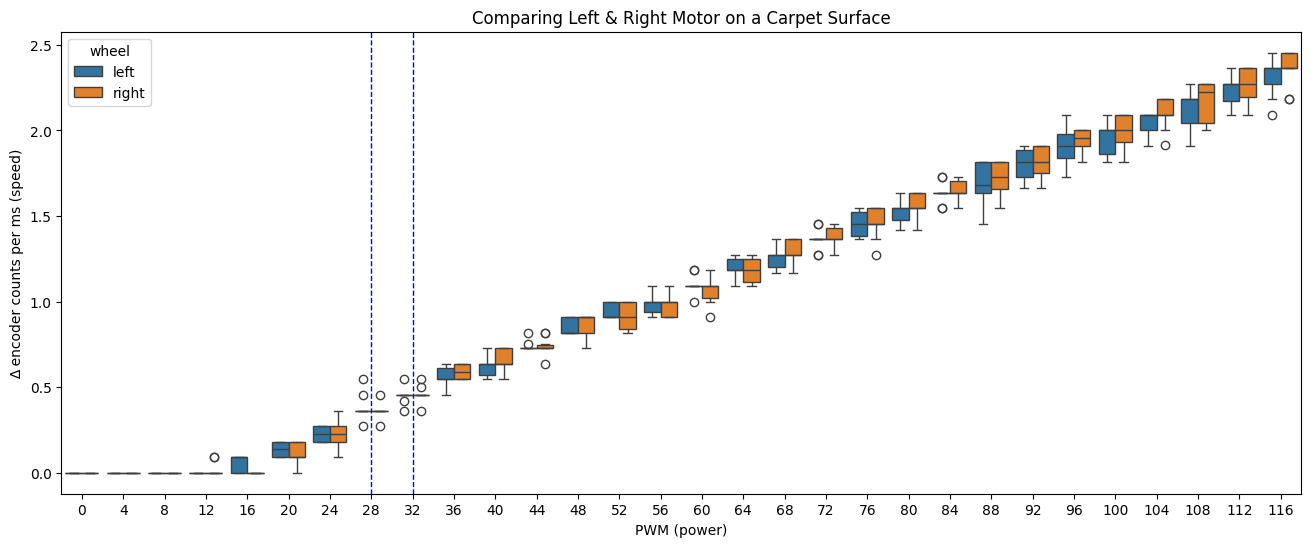

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import CSV stored on github.
# This could be your local computer directory
pwm_speeds = pd.read_csv('https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/refs/heads/main/ExampleData/surfaces.csv', sep=',')
#print( pwm_speeds )

# Let's look at a smaller range of the total PWM
pwm_speeds = pwm_speeds[ pwm_speeds['surface'] == 'carpet' ]
plt.figure(figsize=(16, 6))
bplot = sns.boxplot( data=pwm_speeds, x="PWM", y="enc_per_ms", hue="wheel")
bplot.set_title("Comparing Left & Right Motor on a Carpet Surface")
bplot.set_xlabel("PWM (power)")
bplot.set_ylabel("∆ encoder counts per ms (speed)")
bplot.axvline(x=7, color="blue", linestyle="--", linewidth=1)
bplot.axvline(x=8, color="blue", linestyle="--", linewidth=1)

<hr><br><br><br><br>


# Measuring Wheel Speed

## Exercise 4: Measuring Wheel Speed





It is possible for the 3Pi+ to measure and calculate it's own wheel speed. To do this, we will use **rotary encoders**.  Once the robot can measure it's own wheel speed, we can then write an algorithm to change the PWM in response.  This way, the robot can be programmed to autonomously regulate wheel speed - called **closed-loop control**, or **feedback control**.  

<p align="center">
<br>
<img width="75%" src="https://github.com/paulodowd/SEMTM0042_43/blob/main/Images/3PI_EncoderAssembly.png?raw=true">
<br>
</p>

The above image shows the motor assembly for the 3Pi+ robot.  The encoder is placed at the rear of the motor.  As the motor drives the wheel, or if the wheel is turned by hand, a shaft at the back of the motor rotates a magnet (the small black disk).  This magnet rotates over two small <a href="https://en.wikipedia.org/wiki/Hall_effect_sensor">hall effect sensors</a>, creating a pulsing signal to be read by the Arduino.  The Arduino can count these pulses over time.

We can then measure the wheel speed by using the simple relationship:

<p align="center">
$v = d_{t} / \Delta t$
</p>

where $d$ is our measured distance in either the change of encoder counts or _mm_ at time step $t$, and $\Delta t$ is the change in time between time step $t$ and $t-1$.  


The below plot show wheel speed data collected from a 3Pi+ robot using the rotary encoder signal.  For each value of PWM in intervals of 10, 45 samples were taken at 100hz (10ms intervals).  The robot was evaluated in 2 different scenarios: operating on a smooth table top, and operating on a carpet.  

The plot shows that the measured wheel speed varies between these scenarios, but generally has a linear relationship.  By looking at the length of each box (and whiskers), we see that as PWM increases, so does the variability of the speed.  This is our first sign that PWM (**power**) does not equal wheel speed (**velocity**).

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** In this exercise, we will complete some code to make a regular measurement and estimate of wheel speed.  To do this, you will need to draw on some **global variables** which have been defined in `enconders.h`.  The `encoders.h` file has been completed for you and does not need any modification. Therefore, you only need to ensure that `encoders.h` is in your Arduino sketch folder, and that you have the line `#include "encoders.h"` at the top of your program.  As long as you call `setupEncoder0()` and `setupEncoder1()` in your `setup()` function, your robot is already counting the encoder pulses for you as an automatic background process.  You can then use the encoder counts by simply accessing the variables `count_e0` and `count_e1`, as shown in the code extract below.

1. Review the below code extract and then complete the areas idenfitied `????` or with comments.  
  - It is recommended you complete this simpler code, rather than attempting to integrate into your current code.  You can either copy the `encoders.h` file from the <a href="https://github.com/paulodowd/SEMTM0042_43/tree/main/3Pi_CodeStub">code stub provided to you</a> into a new sketch, or you could work from a new copy of the code stub.
  - The below code extract does not convert the measurement into mm per second.  This is optional.  With the below code extract, you will get speed as a measurement of "encoder counts per ms".  

```c
#include "encoders.h"

unsigned long speed_est_ts; // timestamp for speed estimation
#define SPEED_EST_MS 10     // estimate speed every 10ms

// This will store the previous count of pulses from encoder 0
// To estimate speed, we will need to know the difference in
// encoder counts over time.
long last_e0;

// Let's store wheel speed as a global float
float speed_e0;

void setup() {
  setupEncoder0();
  setupEncoder1();

  // This takes the initial count from encoder 0
  // and saves it as the "last" (previous) count
  last_e0 = count_e0;

  // Assuming we start with motors off.
  speed_e0 = 0.0;

  // Capture the time the robot has started, so
  // that we can then know when 20ms has elapsed.
  speed_est_ts = millis();
}

void loop() {

  // Create an if() block here that uses the above
  // speed_est_ts and SPEED_EST_MS variables to
  // only conduct a speed estimate every 10ms
  unsigned long elapsed_time = ????;
  if( ???? ) {

    // Work out the difference in encoder counts
    long count_difference = last_e0 - count_e0;

    // Save the current count as the last count
    // for the next time we do this (10ms in the
    // future).
    last_e0 = count_e0;

    // Take into account time in your measurement.
    // This operation may not happen at exactly
    // 20ms.
    // Remember to typecast into float if you are
    // dividing.  A division on a long will lose
    // any numbers after the decimal place.
    // ...
    speed_e0 = ????;

    // Report the result, so that it can be viewed
    // on the Serial Plotter.
    Serial.println( speed_e0, 4 );
  }

}
```

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Validate that you are able to make a measurement of speed by looking at the value on the Serial Plotter.  To begin with, rotate the wheel slowly by hand, then try integrating your code to operate the motors.  

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left"> **Caution:** Rotating the wheels very fast or hard by hand can **permanently damage the motor gearbox**.  If you are moving the wheels by hand, try to rotate the wheel with gradual, not sudden, changes of speed.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** The **Serial Plotter** sometimes has an automatic scale that is too large to see small values.  To get around this, you can simply multiply a variable when you provide it as an argument to Serial.print().  For example, `Serial.print( speed_e0 * 10.0, 4);` will increase the reported value by a factor of 10.  This does not change the value stored in `speed_e0`, because there is no assignment operator (`=`).

<hr><br><br><br><br>

## Exercise 5: Improving Speed Measurement

You may notice that your measurement of speed can appear "choppy" or with a regular pattern a little like a square-wave. This is due to **quantisation error**.  The encoder is taking a continuous signal (rotation) and transforming this into a digital representation.  The encoders provide **358.3** counts for every 360 degrees of rotation.  That means that there is a certain degree of periodic inaccuracy in our measurement.  


<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/hypothesis.png" align="left">**Hypothesise:** Quantisation error occuring through digitisation is certainly one cause of inaccuracy in our speed estimate.  However, there are probably other likely causes.  What might these be? What would be a way to measure and observe their effect?


We can "smooth" our speed measurement by applying a simple **low-pass** filter.  This means that slow frequency changes are permitted (pass), but high frequency changes are rejected.  In our case, a "slow frequency change" is our estimate of wheel speed, whilst the high-frequency change is the quantisation error.  

The below equation is an <a href="https://en.wikipedia.org/wiki/Exponential_smoothing">Exponential Moving Average</a>.  It is useful because we can "average" (our low pass filter) a signal without storing and iterating over a list of samples.  
<p align="center">
$S_{t} = (\alpha * x_{t}) + ( (1.0 - \alpha) * S_{t-1} )$
</p>

where: $S_{t}$ is the result of our filter (S for "smoothed") at time $t$; $\alpha$ is the **smoothing factor**, and should be a value in the range [ 0.0 : 1.0 ]; and $x_{t}$ is our measurement at time $t$.  We can therefore understand that $S_{t-1}$ means the previous result of our filter, where $t-1$ means "in the last time step".  

We can understand this equation more informally: we can regard the $(\alpha * x_{t})$ component to mean, "how much of the new value do we want to preserve?".  And then the second compoent, $( (1.0 - \alpha) * S_{t-1}) )$ to mean "how much of the historic value do we want to preserve?".   Therefore, if we set $\alpha = 0.1$, our "historic value" has a weighting of 0.9, which means it will influence the filter more than the new reading - which should mean a "smoother" signal.  If we set $\alpha = 0.7$, then the "historic value" will now have significantly less influence than the most recent reading - which should mean a "noisier" signal.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Implement a low-pass filter of the form described above to be applied to both the left and right wheel speed estimates individually.  Remember that, we will want the previous value $S_{t-1}$ to be persistent, so we should make this a global variable (or similar, if you are working in a class).  Remember to work in small steps - so start with one wheel first.




1. It is recommended to implement the low-pass filter within your `loop()` to begin with, just to validate that it is working.  You only want to update your low-pass filter when a new measurement is ready. Therefore, update your low pass filter immediately after the calculation of the speed estimate, within the `millis()` task scheduling block.
  - Remember to initialise the value of your low-pass filter within `setup()`.
  - Use the `Serial.print()` commands to output both the original speed estimate value and the low-pass filter value.  Report these as comma seperated values, so that they can be viewed on the **Serial Plotter**.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/observation.png" align="left"> **Observations:** Take some time to observe the effect of different values of $\alpha$.  Try extreme values such as 0.001, and 0.999.  What do you notice, comparing the original estimate, and the low-pass filter value on the Serial Plotter?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Take some time to consider edge-cases and error-cases.  Therefore, try writing some code within your `loop()` that will gradually vary either the demand speed (if using a PI-Controller), or the PWM (if using open-loop control).  Try also varying the demand speed or PWM suddenly - how does the filter respond?  What would be a sensible value of your filter if the robot was to stop for a period of time, and then begin moving again?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** The Exponential Moving Average is a very useful equation to memorise that can be used elsewhere.  However, it is important to also recognise that when we utilise a digital filter, we unavoidably introduce lag (delay in our signal).  This is because it will take time to process some incoming signal into a new output signal.  As a general rule, the stronger the effect of the filter, the more lag we can expect to observe.  

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** If we have another process interacting with the world that has a time-critical nature, then we must ensure our filter is operating at a faster rate in an attempt to mitigate the lag.  For example, if we only update our filter at the same time as we update our time-critical process, our time-critical process will always have out of date information from the filter (lagged, delayed).    Imagine trying to catch a ball if there was a delay in your sensor signal.  This principle will be true if you are using the **PI-Controller**.

<hr><br><br><br><br>

# Closed Loop Control (PID)



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/tick.png" align="left">To develop a PID controller, you will need to have completed the following:


- the `Motor_c` class, especially the ability to call a function that takes a negative PWM and configures the motor correctly (e.g. `motors.setPWM( -50, 50 );`)
- the previous exercise on measuring wheel speed.



<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/theory.png" align="left">   A nice example of PID being used for smooth motion control is the following video of an e-puck robot tracking a ball with a low-resolution camera: <a href="https://www.youtube.com/watch?v=Pga71leqf1A">YouTube</a>.  Whilst not documented alongside the video, it appears at least two PID controllers are being used:
(1) tracking left to right position of ball, (2) tracking a set distance from the ball.

<p align="center">
<img src="https://github.com/paulodowd/SEMTM0042_43/blob/main/Images/PID_Overview.png?raw=true">
</p>

The above diagram illustrates the general form of a PID controller.  Outside of the blue-dotted box, we can see that a measurement from the system output $y(t)$ is combined with a desired measurement $r(t)$, to form the error signal, $e(t)$:

<p align="center">
$e(t) = r(t) - y(t)$
</p>

When we review the above diagram and equation, we can draw a very general but important understanding: the PID controller is acting a bit like a "transformer" - it takes in one type of units of measurement as the demand (wheel speed), and outputs another type of units to effect change (PWM, via `analogWrite()`).  Therefore, when we tune a PID controller, we are searching for the parameters that provide this relationship.  

For the following exercises a complete PID class has been provided for you in <a href="https://github.com/paulodowd/SEMTM0042_43/tree/main/3Pi_CodeStub">the code stub</a> in the header file `PID.h`, with the class template `PID_c`.  You may also find it useful to review pseudocode, such as on <a href="https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller#Pseudocode">this Wikipedia page</a>.

Our main task in the following exercises is to learn to take steady and procedural steps to tune a PID controller.  This means finding appropriate values of the gains $K_{p}$, $K_{i}$ and $K_{d}$ through a process of trial and error.  

## PID Position Controller, or PID Speed Controller?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/theory.png" align="left"> We know that the robot has rotary encoders attached to the motors.  These are used to count the incremental rotation of the wheels.  When considering how the robot can be commanded to move, there are two possible approaches.  One would be to control the **position** of the wheel, and the other is to control the **wheel speed** (angular rate).  Because we have a discrete count of wheel rotation, it may feel like the obvious choice is a position controller.  However, in our task, controlling position may be less useful.

A **position controller** would be very useful if we had a system that was required to move between positions, and if the total range of those positions was in some regards known before hand (or, existed within bounds).  It would also be very convenient if we had 1 actuator responsible for 1 degree of freedom.  A good example of this would be the print head on a 3D printer, which is typically a single actuator moving an effector along a rail of known fixed length.

If we consider our mobile robot, it has two motors that together will impact the final position of the robot.  Each motor can work independently or together to effect two degrees of freedom (translation and rotation).  Furthermore, if we attempted position control, we could expect a demanded position to be across such extreme and potentially unbounded values:
- 50 counts, to perform a small rotation on the spot.
- 5000 counts, to translate the robot across a reasonable distance.
- 20000 counts, to translate the robot across a far distance.

A good question to ask here is: _"what gain values ($K_p, K_i, K_d$) would be sensible across these ranges of demand position?"_  The answer is **none**.  Consider: if we found some reliable PID gains for movement across a position range of 100 counts, then for an extreme input (e.g. 5000 counts), our controller would **saturate** it's output - this means it would power the actuator at 100%.  Whilst the robot is attempting to reach the extreme demand, it would also appear to be in error the whole time, and so the integral term would **wind-up** to an inappropriate value.  In this regard, even though the position controller is generating motion, the controller is **unresponsive**.

To use a position controller, it would be necessary to perform some path planning to break up large movements into smaller movements - this would help to keep the **input demand** to the controller sensible, and so also keep the controller **responsive**.

In our task context, there is another aspect to consider about using a position controller to move the robot. To attempt to perform travel in a straight line, we could initialise the system by resetting the encoder counts to 0, and then asking the controller to move each wheel by a demand count - such as +1000.  The problem with this approach is that **we do not have good control of the wheel speeds** (or motor response) - and so simply moving the wheels by a count is unlikely to produce straight motion.  

The below graphic attempts to illustrate this concept and effect, where motors differ in their response to the same position demand:

<p align="center">
<br><img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/position_control.png" align="left"><br><br>
</p>

In the above graphic, we can see that the motors **arrive with the same encoder counts**, but the path the robot took was not straight.  The left motor activated and deactivated faster than the right motor.  Therefore, the robot pivoted on the right wheel and then pivoted on the left wheel.

It may be possible to find PID gains for the left and right motor that give rise to the same response for each motor.  However, this is likely to be very challenging to achieve.   This is especially true if we consider the first discussion about position control in our task potentially having unbounded input demands of position.

Instead, we know that **there is a clearly bounded range of wheel speeds that are useful for our robot**.  This means that we are much more likely to be able to optimise a set of PID gains to produce a quick and reliable response to a given input speed demand.  If a quick response can be found to achieving a demand wheel speed, then the resultant motion becomes more controlled overall.

<hr><br><br><br><br>

## Exercise 6: PID Preparation

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** To get started, we will need to select some parameters that will make tuning our PID-Controller easier.  Tuning a PID controller can quickly become confusing.  Therefore, we want to keep as many variables under our control as possible.  We want to take small steps, each time **validating** that everything is working as we expect or understand it to.

1. Select a wheel speed measurement value that represents steady movement from your 3Pi+ robot - this means, not a fast speed!  We will use this wheel speed value as our future demand value for PID.
  - Your wheel speed measurment is likely to be in either `encoder counts per ms` or `mm per ms`.  
  - If you have decided to use another unit, such as `meters per second`, you are likely to measure very small values - this might cause you difficulties when plotting or reviewing the measurements.  Intuitively, the unit of a meter per second is not especially relevant to such a small robot.
  - To find a good value, simply use some PWM values in `analogWrite()`, and report the measured wheel speed via `Serial.print()`.

2. Review the class provided for you, `PID_c`.  

3. Implement the following general structure into an Arduino sketch, including the other relevent parts of code (e.g., encoders, your speed measurement, etc).

```c
#include "PID.h"

PID_c left_pid; // Let's just work with one motor to start

float demand;   // Demand wheel speed.

// We will use a timestamp and millis to change our
// demand periodically, to test the response of the
// PID
unsigned long test_ts;
#define TEST_MS 2000

void setup() {

  // Initialise all gains to zero for now.
  left_pid.initialise( 0.0, 0.0, 0.0 );

  // Prepare our testing timestamp
  test_ts = millis();

  // Remember to reset your PID if you have
  // used any delay()
  left_pid.reset();
}

void loop() {

  // This flips the demand to be a wheel
  // speed in the other direction every
  // TEST_MS.  
  if( millis() - test_ts > TEST_MS ) {
    test_ts = millis();

    demand = demand * -1.0;
  }

  // You will need to ensure you are calculating
  // an estimate of wheel speed.
  // ...
  // ...


  // You should encapsulate the following line within
  // a task scheduling millis() block, similar to the
  // above. You should schedule your pid update to be
  // at a frequency slower than your speed estimate is
  // updated.  Try 50ms.
  // replace "measurement" with your wheel speed
  // measurement variable.
  float l_pwm = left_pid.update( demand, measurement );

  // Just test the left motor
  motors.setPWM( l_pwm, 0 );

  // Serial prints to help us debug and tune
  Serial.print( demand );
  Serial.print( "," );
  Serial.print( measurement );
  Serial.print( "\n" );

}


```

## Exercise 7: P-Controller





<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Integrating your code with the above code extract, follow the next steps to **validate** that your system is operating as you expect.   You should complete these steps **without activating the motor power**.

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_checking_demand_measurement.png"><br>
<small>Checking demand and measurement change . Note, the values are scaled up by 100 to make them visible.  The blue line is the demand value, which is alternating every 2000ms.  The red line is the speed measurement, achieved by moving the left wheel by hand.</small>
</p>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Validate that when you have a **positive demand value**, rotating the wheel by hand to move the forward robot **decreases the distance** between your **demand and measurement** via the plotter.  When the demand flips to negative, validate that the wheel rotation in the other direction approaches this negative demand value.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/observation.png" align="left"> **Observations:** The error within the PID ($e_{t}$) will be the difference between the **demand** and **measurement**. Therefore, when you are rotating the wheel by hand, you are acting at the PID controller to **minimise the error** (make the measurement match demand).

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Manually set a positive PWM value via `analogWrite()` or `motors.setPWM();`, and check that this relates to a positive speed measurement (positive direction of travel).  Once you have validated this, remove the `analogWrite()` or `motors.setPWM()` used for this test.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Add a `Serial.print()` command to also output the error calculated by `left_pid.update();`.  Check within the class template for the exact syntax.  You should be able to access `left_pid.last_error` from within `loop()`.  Check whether the error is reporting as positive or negative when the **demand is positive**.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/hypothesis.png" align="left">**Hypothesise:** When the **demand is positive**, and we want a **positive PWM output**, what sign should $K_{p}$ have to achieve this effect?  This will depend on the sign of your error measurement.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/observation.png" align="left"> **Observations:** Relating to the above hypothesis, observe that the sign of the error will depend on whether it is calculated as `demand - measurement`, or `measurement - demand`.  Either of these is correct, or rather, neither is incorrect.  Which to use will depend entirely on how your have implemented your system.  Is your speed measurement positive for a forward direction of travel?  Is your PWM sign positive for a forward direction of travel?  It is important to have a clear understand of how these aspects inter-relate.  Overall, **what we want to happen** is for the **error to be minimised by outputting a useful PWM signal**.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Find the line `left_pid.initialise( 0.0, 0.0, 0.0 );` and change the first argument to a **guess** for a correct value.  As a general rule, start lower than you expect.  
  

- Remember, a P-Controller will multiply the error by $K_{p}$ to produce the output.  Therefore, for the error values you have been observing with your tests, what value of $K_{p}$ is **likely** to produce a useful PWM output value?
- Adjust your $K_{p}$ value and observe the effect.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/stop.png" align="left"> Allowing the motor to **run at high speed for a long time** will cause the motor to **overheat** and become **permanently damaged**.  You will **smell this happening** - don't let it happen!  If you have a problem with your code you **should turn the robot off whilst you work on solving it**.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** Your robot and PID controller are going to perform differently when **off the surface** and **on the surface**.  Start your testing with the robot off the surface.  However, you will find that the performance is generally **improved on the surface**, because the mechanics and dynamics of the robot will **dampen** the reponse (reduce oscillations).  Remember that we are tuning the PID controller for it's real application (on the surface!).

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** We are currently investigating just one motor. However, it may be difficult if your robot is driving in circles, and so twisting the USB cable.  A quick solution is to send the feedback for the left motor (`l_pwm` in the code extract above) to both motors (e.g., `motors.setPWM( l_pwm, l_pwm );`.  **This is not our final solution!**.  It would mean the right motor was not operating in closed-loop control.  Towards the end of these exercises, we will create a second PID controller for the right motor.

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_kp_too_small.png"><br>
<small>This is an example output where $K_{p}$ was **too small**.  We can read the red line (measurement) to understand that the motor was occasionally activating, but lacked sufficient power overall.</small>
</p>


<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_kp_too_big.png"><br>
<small>This is an example output where $K_{p}$ was **too big**.  We can read the red line (measurement) to understand that the motor was activating with too much power, which caused the error to flip, and send the motor immediately in the opposite direction (oscillation).  </small>
</p>

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_kp_onOff_surface.png"><br>
<small>This is an example output where $K_{p}$ has a value that is **good enough**.  We can read the red line (measurement) to understand that the motor is activating in the right direction, but never matches the demand.  This is known as **steady-state error**.  With a P-Controller for wheel speed, this is the best that can be achieved.  Also notice that, when the robot was lifted off the surface, the P-Controller went into oscillation.</small>
</p>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/hypothesis.png" align="left">**Hypothesise:** A P-Controller for wheel speed will not be able to match measurement to demand.  Why might this be?  Consider what happens to the error ($e_{t}$) when the measurement is near to demand, and the relationship with $K_{p}$.  

<hr><br><br><br><br>

## Exercise 8: PI-Controller

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/theory.png" align="left">   The **I-term** of PID has a reputation for being difficult and confusing.  Therefore, we will take incremental steps to test and validate the I-term alone, before testing a full PI-Controller (P-term and I-term combined).  



We can informally understand the I-term to: _"integrate error whilst the system remains in error"_.  This means that, if the motor power is off, the I-term will grow in magnitude over time.  This is because the motors are not moving, and yet there is a demand - creating a persistent error.  Therefore, when we later turn the motors on, the I-term will give a huge feedback value (PWM), causing the robot to zoom of the table.  This is known as **integral wind-up**, and it has something of a bad reputation.  Integral wind-up is a difficult issue in a position controller, where we want a mechanism to come to a stop at a precise position (like a gantry, or 3D printer).

In our system, some integral wind-up is desirable.  Consider, in our system, if we stop providing power to the motor (PWM), the motor will slow down and stop.  This is similar to a quadcopter (UAV, drone) - if we reduce the power to the rotor motors, the quadcopter will descend or fall out of the sky.  

In the last exercise, we also **observed** that as the P-term increased the motor power to reach demand, the error reduced towards 0, and this causes an inherent problem: a P-Controller for wheel speed cannot match demand.  As soon as the P-Controller gets close to the demand, $K_{p}$ operates on a very small error and effectively disables the motors.  We have observed this as **steady-state error**.

We want **integral wind-up** to fix this steady-state error.  It is useful to think that:
- The P-Term will give the initial movement, overcoming stiction and other properties.
- The I-term will fix steady-state error, effectively "lifting" the output to reach demand.

In the following exercises, we will start by **validating** that the I-term is operating in the way we understand and expect.  We will do this by focusing on just the I-term first.


<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** In preparation, temporarily disable the periodic change to the demand.  You can do this by commenting-out the line `demand = demand * -1.0;`.  If the demand is changing, this will get confusing.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Find the line `left_pid.initialise( 0.0, 0.0, 0.0 );` and change the second argument to a very small value, such as `0.001`.  Leave the other arguments as 0.0 - e.g. `left_pid.initialise( 0.0, 0.001, 0.0 );`.  The I-term can integrate very quickly, and then cause crazy oscillations very quickly.  Therefore, start with $K_{i}$ very small.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/validate.png" align="left"> **Validate:** Add a `Serial.print()` command to print the I-term from the PID class.  Check the `PID_c` class template for the syntax.  You should be able to use `left_pid.i_term;` from `loop()`.  **With the motors off**, check the output of the I-term using the Serial Plotter. Verify that for a positive demand, the I-term is increasing.  Once you have done this, validate that for a negative demand, the I-term is decreasing.

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_small_iTerm_growing.png"><br>
<small>This is an example output where $K_{i}=0.001$, and the **I-term** is the green line.  We can see that the blue line (demand) is constant and positive, whilst the red line (measurement) is constant and 0.  Therefore, the system has persistent errro.  We can read the green line to understand that I-term is integrating this error over time, and therefore increasing in magnitude.
 Because the I-term is moving towards the demand, we can validate it as operating correctly.</small>
</p>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Once you have validated that your I-term is operating as expected, try activating your motor power.  With $K_{i}$ set to a small value, you should hear and then see a very slow and gradual increase of wheel speed.  You can use the Serial Monitor to view the current value of the I-term.  Note that this will be the PWM value output (with the P-term currently disabled, $K_{p}=0$).  It should therefore make sense that the motor is taking a very long time to increase in speed.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/observation.png" align="left"> **Observations:** Testing in cycles of programming your robot, try increasing the value of $K_{i}$ in small increments, and observe the effect.

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_slow_iTerm_effect.png"><br>
<small>A plot of the I-term with the motor power activated.  The the green line is the I-term, the blue line is the demand, the red line is the measurement.  This plot shows a response when $K_{p}=1$, $K_{p}=0.01$ and $K_{d}=0$.  $K_{i}$ is still too small, so the system is responding slowly.  However, it does match demand to measurement.  </small>
</p>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** In the above plot, we see that the I-term is increasing for a period, and yet the **measurement** remains zero.  The specialist term for this phenomenon with motors is called **deadband**.  One of the impacts of **deadband** is that a range of PWM values are essentially non-functional (produce no rotation output).  Therefore, if deadband is not addressed, your robot will not be able to move at low (slow) speeds.  A PI-Controller can mitigate this by strobing the output, which is a bit like applying PWM to the PWM signal generated by `analogWrite()`.  Therefore, an advantage of a PI-Controller is the ability to drive at slow speeds.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/hypothesis.png" align="left">**Hypothesise:** In the above plot, from approximately sample 6500 (x-axis) we see that the I-term stops growing - why is this?  How is this effect created? Why does the I-term not continue to **wind-up**?

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Try increasing the value of $K_{i}$ further, to achieve a quicker response to match demand to measurement.  You should notice that your system becomes prone to oscillating.  This is because the I-term has become too **coarse**, it is responding too aggressively to steady-state error, and so jumping the output signal too much and too fast.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Add your P-term ($K_{p}$) back into your `left_pid.initialise( );` call.  Because the P-term and I-term are now working together, you may need to reduce both $K_{p}$ and $K_{i}$.  Explore different values of these gains.

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/L1_iTerm_reasonable.png"><br>
<small>A plot of a PI-Controller with reasonable tuning - but it could still be improved further.  This plot has been selected because we can still clearly observe the additive effect of the P-term and I-term. Note that the demand matches measurement quite quickly initially, and the I-term continues to integrate at a reasonable pace. </small>
</p>

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/info.png" align="left"> **Information:** In the above plot, we can still observe noise on the speed measurement.  Importantly, you should evaluate whether this has a significant effect in the obervable performance of your robot.  It is unlikely that all noise can be mitigated - instead, we want to assess the real-world performance of our robot to understand if the noise is significant or not.

<img src="https://raw.githubusercontent.com/paulodowd/SEMTM0042_43/main/Images/exercise.png" align="left">  **Exercise:** Once you are happy with the $K_{p}$ and $K_{i}$ gains for your left motor, try reproducing this work for the right motor.  You can try using the same gains.  However, you should also expect better performance if each motor is tuned individually.  Note that, to operate another PID controller for the right motor, you can create a second instance of the `PID_c` class, as shown below:

```c
#include "PID.h"

PID_c left_pid;  // To control the left motor
PID_c right_pid; // To control the right motor


float demand;   // Demand wheel speed.

// We will use a timestamp and millis to change our
// demand periodically, to test the response of the
// PID
unsigned long test_ts;
#define TEST_MS 2000

void setup() {

  // Initialise all gains to zero for now.
  left_pid.initialise( 0.0, 0.0, 0.0 );
  right_pid.initialise( 0.0, 0.0, 0.0 );

  // Prepare our testing timestamp
  test_ts = millis();

  // Remember to reset your PID if you have
  // used any delay()
  left_pid.reset();
  right_pid.reset();
}

void loop() {

  // This flips the demand to be a wheel
  // speed in the other direction every
  // TEST_MS.  
  if( millis() - test_ts > TEST_MS ) {
    test_ts = millis();

    demand = demand * -1.0;
  }

  // You will need to ensure you are calculating
  // an estimate of wheel speed.
  // ...
  // ...


  // You should encapsulate the following line within
  // a task scheduling millis() block, similar to the
  // above. You should schedule your pid update to be
  // at a frequency slower than your speed estimate is
  // updated.  Try 50ms.
  // replace "measurement" with your wheel speed
  // measurement variable.
  float l_pwm = left_pid.update( demand, measurement );
  float r_pwm = right_pid.update( demand, measurement );

  // Just test the left motor
  motors.setPWM( l_pwm, r_pwm );

  // Serial prints to help us debug and tune
  Serial.print( demand );
  Serial.print( "," );
  Serial.print( measurement );
  Serial.print( "\n" );

}


```

<hr><br><br><br><br>

<hr><br><br><br><br>